In [109]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import cv2

### Read Data from API

In [23]:
document_id = "1"
get_document_url = f"http://localhost:8000/document_generator/documents/{document_id}"
get_boxes_url = f"http://localhost:8000/document_generator/{document_id}/boxes"

In [31]:
def get_image_and_boxes(document_id: str):
    with requests.Session() as session:
        res_document = session.get(get_document_url)
        res_boxes = session.get(get_boxes_url)
    
        if res_document.status_code == 200 and res_boxes.status_code == 200:
            document_image_url = res_document.json()["image"]
            boxes = res_boxes.json()
            res_image = session.get(document_image_url)
    
            if res_image.status_code == 200:
                image = res_image.content
            else:
                raise ValueError(f"could not retrieve the image error: {res_image.status_code}")
        else:
            raise ValueError(f"could not retrieve the document and the boxes errors: {res_document.status_code}, {res_boxes.status_code}")
    
    return image, boxes

In [89]:
def denormalise_box_coordinates(start_x_norm, start_y_norm, end_x_norm, end_y_norm, doc_width, doc_height):
    start_x = start_x_norm * doc_width
    end_x = end_x_norm * doc_width
    start_y = start_y_norm * doc_height
    end_y = end_y_norm * doc_height
    
    return start_x, start_y, end_x, end_y

In [86]:
document_image, boxes = get_image_and_boxes(document_id)

In [87]:
document_image = Image.open(BytesIO(document_image))

In [88]:
document_image.height, document_image.width

(1030, 690)

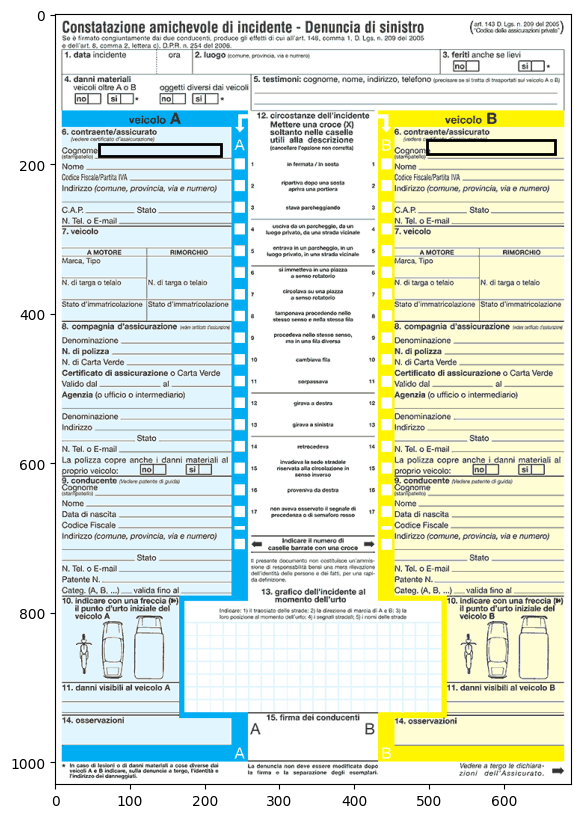

In [90]:
fig, ax = plt.subplots(figsize=(10, 10))

# print image
ax.imshow(document_image)

# print boxes
for box in boxes:
    start_x, start_y, end_x, end_y = denormalise_box_coordinates(box["start_x_norm"], box["start_y_norm"], 
                                                                 box["end_x_norm"], box["end_y_norm"],
                                                                 doc_width=image.width, doc_height=image.height)
    x, y, width, height = start_x, start_y, end_x - start_x, end_y - start_y, 
    box_rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(box_rect)

plt.show()

In [74]:
boxes

[{'id': 13,
  'name': 'test_cognome',
  'is_alphabetic': True,
  'is_numeric': False,
  'mean_length': 15,
  'start_x_norm': 0.7212389380530974,
  'start_y_norm': 0.16296296296296298,
  'end_x_norm': 0.9690265486725663,
  'end_y_norm': 0.18074074074074073,
  'document': 1}]

### Read letters database

In [97]:
labels = pd.read_csv("../handwritten_dataset/labels.csv")

In [98]:
labels.head()

,image,label
0,images/img001-001.png,0
1,images/img001-002.png,0
2,images/img001-003.png,0
3,images/img001-004.png,0
4,images/img001-005.png,0


In [105]:
labels[labels["label"] == "1"].head(2)

,image,label
55,images/img002-001.png,1
56,images/img002-002.png,1


In [121]:
letter_image_0 = cv2.imread("../handwritten_dataset_processed/images/img001-001.png", flags=cv2.IMREAD_UNCHANGED)

In [123]:
letter_image_1 = cv2.imread("../handwritten_dataset_processed/images/img002-001.png", flags=cv2.IMREAD_UNCHANGED)

In [141]:
letter_0_height = letter_image_0.shape[0]

In [142]:
letter_1_height = letter_image_1.shape[0]

In [143]:
max_height = max(letter_0_height, letter_1_height)

In [144]:
max_height

586

In [146]:
max_height - letter_1_height

92

In [ ]:
# pad images to fit the largest one
for image in 

In [ ]:
cv2.hconcat()

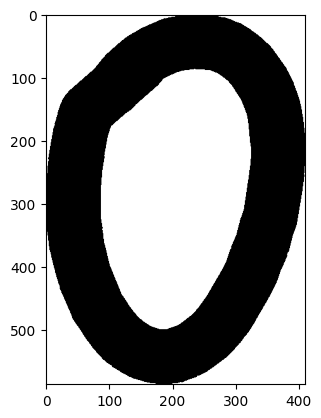

In [130]:
plt.imshow(letter_image_0)

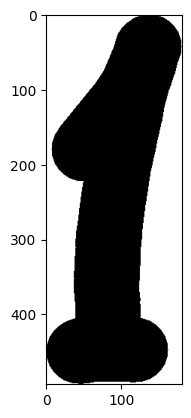

In [118]:
plt.imshow(letter_image_1)

In [136]:
cv2.hconcat([letter_image_0, letter_image_1])

error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/core/src/matrix_operations.cpp:67: error: (-215:Assertion failed) src[i].dims <= 2 && src[i].rows == src[0].rows && src[i].type() == src[0].type() in function 'hconcat'


### Generate samples